# Lab

### Configuration

In [254]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15


def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects: list[LinesCollection] = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [255]:
class Scene:
    def __init__(self, points = None, lines = None):
        self.points = points or []
        self.lines = lines or []

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = None, points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes or [Scene()]
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

    @staticmethod
    def save_to_file(self, file_name: str):
        plt.savefig(file_name + '.png' if file_name.find('.') == -1 else file_name)
        

### Rozwiązanie

In [256]:
from typing import Callable
from enum import Enum
import functools
# import RBTree

#config
epsilon = np.float64(1e-8)

point_type = tuple[np.float64, np.float64]
rectangle_type = tuple[point_type, point_type]
bound_vector_type = tuple[point_type, point_type]
matrix_type = list[list[np.float64]]

INF = float("inf")


class ChainClassification(Enum):
    LEFT = -1
    RIGHT = 1

class PointRelativePosition(Enum):
    LEFT = 1
    COLLINEAR = 0
    RIGHT = -1

class PointsOrientation(Enum):
    CCW = 1
    COLL = 0
    CW = -1

class PointType(Enum):
    STARTING = 1
    ENDING = 2
    CONNECTING = 3
    DIVIDING = 4
    CORRECT = 5


class PointClassifier:
    def __init__(self, collinear_tolerance: np.float64, point_det_function: Callable[[point_type, point_type, point_type], np.float64]):
        self.calc_det = point_det_function

        self.collinear_tolerance = collinear_tolerance

    def classify_rel_to_vector(self, point: point_type, vector: bound_vector_type):
        det = self.calc_det(vector[0], vector[1], point)

        if abs(det) < self.collinear_tolerance:
            return PointRelativePosition.COLLINEAR
        if det > 0:
            return PointRelativePosition.LEFT
        if det < 0:
            return PointRelativePosition.RIGHT


def create_2x2_matrix(a: point_type, b: point_type, c: point_type):
    return [
        [a[0] - c[0], a[1] - c[1]],
        [b[0] - c[0], b[1] - c[1]]
    ]


def calc_det(matrix):  # calculation of matrix det written for WDI
    def calc_det_recur(_matrix, y, il, poss, perm, inv):
        if y >= len(matrix):
            nonlocal su

            if inv % 2 == 0:
                sign = 1
            else:
                sign = -1

            su += sign * il
            return il

        for curr_i in poss:
            inv_c = inv
            for perm_el in perm:
                if perm_el > curr_i:
                    inv_c += 1

            calc_det_recur(_matrix, y + 1, il * _matrix[y][curr_i], [i for i in poss if i != curr_i], perm + [curr_i],
                           inv_c)

    su = 0
    poss = [i for i in range(len(matrix))]
    for curr_i in range(len(matrix[0])):
        calc_det_recur(matrix, 1, matrix[0][curr_i], [i for i in poss if i != curr_i], [curr_i], 0)

    return su

form RBTree import RBTree
# from RBT import RedBlackTree as RBTree

class EventStructure:
    class EventType(Enum):
        SEGMENT_BEGINNING = 1
        SEGMENT_END = 2
        INTERSECTION = 3

    event_type = tuple[np.float64, EventType, tuple]

    def __init__(self):
        self.tree = RBTree(self.comparator)

    def add_event(self, event_type: EventType, event_priority: np.float64, event_data: tuple):
        event = (event_priority, event_type, event_data)
        self.tree.add_node(event)

    def comparator(self, event1, event2):
        print("compared_events", event1[0], event2[0])
        if event1[0] == event2[0]:
            print("equal")
            return 0
        return event1[0] - event2[0]

    def next_event(self):
        return self.tree.min_node().value

    def pop_next_event(self):
        event = self.next_event()
        self.tree.remove(event)

        return event

    def contains(self, event: tuple):
        return self.tree.contains(event)

    def empty(self):
        return self.tree.empty()



class StateStructure:
    def __init__(self, line_segments: list[bound_vector_type]):
        self.tree = RBTree(self.vectors_id_broom_intersection_height_comparator)
        self.line_segments = line_segments
        self.current_x = -INF

    def set_current_x(self, x):
        self.current_x = max(self.current_x, x)

    def vectors_id_broom_intersection_height_comparator(self, s1_id: int, s2_id: int):
        if s1_id == s2_id: return 0
        return self.vectors_broom_intersection_height_comparator(self.line_segments[s1_id], self.line_segments[s2_id])

    def vectors_broom_intersection_height_comparator(self, s1: bound_vector_type, s2: bound_vector_type):
        ys1 = ((s1[1][1] - s1[0][1]) / (s1[1][0] - s1[0][0])) * (self.current_x - s1[0][0]) + s1[0][1]
        ys2 = ((s2[1][1] - s2[0][1]) / (s2[1][0] - s2[0][0])) * (self.current_x - s2[0][0]) + s2[0][1]

        if ys1 < ys2:
            return -1
        return 1

    def add(self, s_id: int):
        self.tree.add_node(s_id)
        print("added to stateStructure", self.tree.find_node(s_id))


        # return self.tree.add_node(s_id)

    def remove(self, s_id: int):
        return self.tree.remove(s_id)

    def swap_places(self, s1_node: RBTNode, s2_node: RBTNode):
        # s1_node.value, s2_node.value = s2_node.value, s1_node.value

        if self.tree.root is s1_node:
            self.tree.root = s2_node
        if self.tree.root is s2_node:
            self.tree.root = s1_node


        s1_parent = s1_node.parent
        s2_parent = s2_node.parent

        if s1_parent is not None:
            if s1_node is s1_parent.left:
                s1_parent.left = s2_node
            else:
                s1_parent.right = s2_node
        if s2_parent is not None:
            if s2_node is s2_parent.left:
                s2_parent.left = s1_node
            else:
                s2_parent.right = s1_node

        if s1_node.left is not self.tree.NIL_LEAF:
            s1_node.left.parent = s2_node
        if s1_node.right is not self.tree.NIL_LEAF:
            s1_node.right.parent = s2_node

        if s2_node.left is not self.tree.NIL_LEAF:
            s2_node.left.parent = s1_node
        if s2_node.right is not self.tree.NIL_LEAF:
            s2_node.right.parent = s1_node

        s1_node.left, s2_node.left = s2_node.left, s1_node.left
        s1_node.right, s2_node.right = s2_node.right, s1_node.right
        s1_node.parent, s2_node.parent = s2_node.parent, s1_node.parent
        s1_node.color, s2_node.color = s2_node.color, s1_node.color


        return s1_node, s2_node

    def ceil(self, s_id):
        return self.tree.ceil(s_id)

    def floor(self, s_id):
        return self.tree.floor(s_id)

    def get_node(self, s_id):
        return self.tree.find_node(s_id)

    def successor(self, node):
        return self.tree.find_inorder_successor(node)

    def precessor(self, node):
        return self.tree.find_inorder_precessor(node)

    def upper_neighbour(self, s_id):
        print("upper of ", s_id)
        node = self.tree.find_node(s_id)

        upper_node = self.tree.find_inorder_successor(node)
        return upper_node.value if upper_node is not None else None

    def lower_neighbour(self, s_id):
        node = self.tree.find_node(s_id)
        lower_node = self.tree.find_inorder_precessor(node)
        return lower_node.value if lower_node is not None else None


def does_intersect(v: bound_vector_type, u: bound_vector_type, points_classifier: PointClassifier):
    u1_pos = points_classifier.classify_rel_to_vector(u[0], v)
    u2_pos = points_classifier.classify_rel_to_vector(u[1], v)

    v1_pos = points_classifier.classify_rel_to_vector(v[0], u)
    v2_pos = points_classifier.classify_rel_to_vector(v[1], u)


    return u1_pos.value * u2_pos.value <= 0 and v1_pos.value * v2_pos.value <= 0


def find_line_equation(v: bound_vector_type):
    a = (v[1][1] - v[0][1]) / (v[1][0] - v[0][0])
    b = v[0][1] - v[0][0] * a

    return a, b

def find_intersection_point(v: bound_vector_type, u: bound_vector_type):
    line_v = find_line_equation(v)
    line_u = find_line_equation(u)

    av, bv = line_v
    au, bu = line_u

    intersection_x = (bu - bv) / (av - au)
    intersection_y = av * intersection_x + bv

    return intersection_x, intersection_y


def find_intersections(lines: list[bound_vector_type], point_classifier: PointClassifier, visualize = False):
    state = StateStructure(lines)
    events = EventStructure()

    for i, line in enumerate(lines):
        start = min(line, key=lambda x: x[0])
        end = max(line, key=lambda x: x[0])
        events.add_event(EventStructure.EventType.SEGMENT_BEGINNING, start[0], (i,))
        events.add_event(EventStructure.EventType.SEGMENT_END, end[0], (i,))


    print(events.tree.in_order(events.tree.root, ""))
    intersections = set()

    while not events.empty():
        event = events.pop_next_event()
        event_type = event[1]

        new_neighbours = []


        print("\n", events.tree.in_order(events.tree.root, ""))
        print(event_type, event[0], event[2], end="\t")
        print("\n", state.current_x, "||", state.tree.in_order(state.tree.root, ""))

        if event_type == EventStructure.EventType.SEGMENT_BEGINNING:
            state.set_current_x(event[0])
            s_id = event[2][0]
            upper_neighbour = state.ceil(s_id)
            lower_neighbour = state.floor(s_id)
            state.add(s_id)

            print(upper_neighbour, lower_neighbour)
            if upper_neighbour is not None: new_neighbours.append([upper_neighbour, s_id, state.get_node(upper_neighbour), state.get_node(s_id)])
            if lower_neighbour is not None: new_neighbours.append([s_id, lower_neighbour, state.get_node(s_id), state.get_node(lower_neighbour)])

        elif event_type == EventStructure.EventType.SEGMENT_END:
            state.set_current_x(event[0])
            s_id = event[2][0]
            print(s_id, state.current_x, state.get_node(s_id))
            state.remove(s_id)

            upper_neighbour = state.ceil(s_id)
            lower_neighbour = state.floor(s_id)

            print(upper_neighbour, lower_neighbour)
            if upper_neighbour is not None and lower_neighbour is not None:
                new_neighbours.append([upper_neighbour, lower_neighbour, state.get_node(upper_neighbour), state.get_node(lower_neighbour)])

        elif event_type == EventStructure.EventType.INTERSECTION:
            s1_id, s2_id, s1_node, s2_node = event[2]
            intersections.add(find_intersection_point(lines[s1_id], lines[s2_id]))

            state.set_current_x((state.current_x + event[0]) / 2)

            # s1_node = state.get_node(s1_id)
            # s2_node = state.get_node(s2_id)

            # temporarily remove
            # state.remove(s1_id)
            # state.remove(s2_id)

            print("\n", state.current_x, "||", state.tree.in_order(state.tree.root, ""))

            # assumption: in the state structure s1 > s2
            print("//===")
            # upper = state.ceil(s1_id)
            # upper = state.upper_neighbour(s1_id)
            upper_node = state.successor(s1_node)
            print(s1_node.parent, s1_node.right)
            print(s1_node, "^", upper_node)
            # print(upper)
            print("===")
            # lower = state.floor(s2_id)
            # lower = state.lower_neighbour(s2_id)
            lower_node = state.precessor(s2_node)
            print(s2_node, "\\/", lower_node)
            # print(lower)
            print("===//")

            s1_node, s2_node = state.swap_places(s1_node, s2_node)
            state.set_current_x(event[0])
            print("\n", state.current_x, "||", state.tree.in_order(state.tree.root, ""))

            # add again using y from the previous event
            # state.add(s1_id)
            # state.add(s2_id)


            # now s1 < s2
            if upper_node is not None: new_neighbours.append([upper_node.value, s2_id, upper_node, s2_node])
            if lower_node is not None: new_neighbours.append([s1_id, lower_node.value, s1_node, lower_node])

        print()
        print(state.tree.in_order(state.tree.root, ""))
        print(new_neighbours)
        print()

        for s1_id, s2_id, s1_node, s2_node in new_neighbours:
            if does_intersect(lines[s1_id], lines[s2_id], point_classifier):
                intersection_point = find_intersection_point(lines[s1_id], lines[s2_id])
                if intersection_point[0] > event[0] and not events.contains([intersection_point[0]]):
                    print("NEW INTERSECTION EVENT", intersection_point[0], s1_node, s2_node)
                    events.add_event(EventStructure.EventType.INTERSECTION, intersection_point[0], [s1_id, s2_id, s1_node, s2_node])

        print("------------")

    print("=-=-=-=-=\n", intersections)
    return intersections


def get_lines_and_find_intersections(input_plot: Plot, point_classifier: PointClassifier):
    lines = input_plot.get_added_lines()[-1].lines
    
    find_intersections(lines, point_classifier)

### Input plot
Kliknij "Dodaj linę", a następnie narysuj wszystkie linie w danym testowym zbiorze lini NIE klikając ponownie "Dodaj linię".

<IPython.core.display.Javascript object>


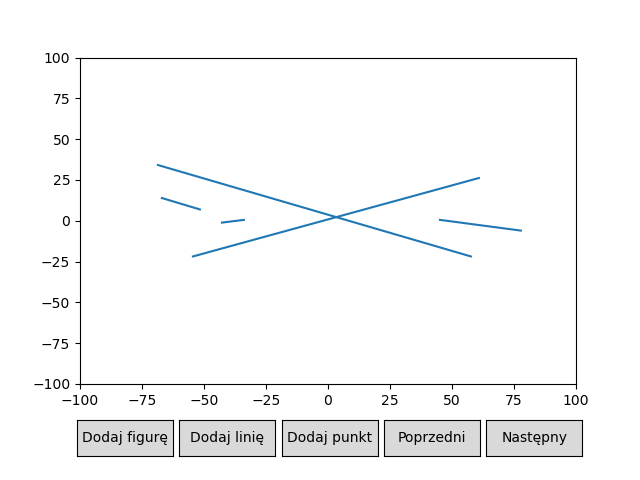

(-100.0, 100.0)

In [212]:
%matplotlib notebook

inp_plot = Plot()
inp_plot.draw()
ax = plt.gca()
ax.set_xlim((-100, 100))
ax.set_ylim((-100, 100))

In [257]:
det_calculation = lambda a, b, c: calc_det(create_2x2_matrix(a, b, c))
pt_classifier = PointClassifier(epsilon, det_calculation)

In [258]:
get_lines_and_find_intersections(inp_plot, pt_classifier)

compared_events 76.171875 -79.07006048387096
compared_events -79.07006048387096 76.171875
compared_events -73.02167338709677 -79.07006048387096
compared_events -79.07006048387096 -73.02167338709677
compared_events -73.02167338709677 76.171875
compared_events 76.171875 -73.02167338709677
compared_events 76.171875 -73.02167338709677
compared_events 76.171875 -73.02167338709677
compared_events -79.07006048387096 76.171875
compared_events -79.07006048387096 76.171875
compared_events 67.70413306451613 -73.02167338709677
compared_events -73.02167338709677 67.70413306451613
compared_events 67.70413306451613 76.171875
compared_events 76.171875 67.70413306451613
compared_events 76.171875 67.70413306451613
compared_events 76.171875 67.70413306451613
compared_events -73.02167338709677 76.171875
compared_events -77.45715725806451 -73.02167338709677
compared_events -73.02167338709677 -77.45715725806451
compared_events -73.02167338709677 -77.45715725806451
compared_events -77.45715725806451 -79.0700

/tmp/ipykernel_58901/2479109255.py:812: RuntimeWarning: invalid value encountered in double_scalars
  intersection_x = (bu - bv) / (av - au)
